6. Calculate the yield of the areas N-9.1, N-9.2, N-9.3 without external effects. Use the long-term corrected ERA5 data as 
input. 

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV
import foxes.constants as FC

# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

Turbine 0, T0: kTI_02, NREL5MW
Turbine 1, T1: kTI_02, NREL5MW
Turbine 2, T2: kTI_02, NREL5MW
Turbine 3, T3: kTI_02, NREL5MW
Turbine 4, T4: kTI_02, NREL5MW
Turbine 5, T5: kTI_02, NREL5MW
Turbine 6, T6: kTI_02, NREL5MW
Turbine 7, T7: kTI_02, NREL5MW
Turbine 8, T8: kTI_02, NREL5MW
Turbine 9, T9: kTI_02, NREL5MW
Turbine 10, T10: kTI_02, NREL5MW
Turbine 11, T11: kTI_02, NREL5MW
Turbine 12, T12: kTI_02, NREL5MW
Turbine 13, T13: kTI_02, NREL5MW
Turbine 14, T14: kTI_02, NREL5MW
Turbine 15, T15: kTI_02, NREL5MW
Turbine 16, T16: kTI_02, NREL5MW
Turbine 17, T17: kTI_02, NREL5MW
Turbine 18, T18: kTI_02, NREL5MW
Turbine 19, T19: kTI_02, NREL5MW
Turbine 20, T20: kTI_02, NREL5MW
Turbine 21, T21: kTI_02, NREL5MW
Turbine 22, T22: kTI_02, NREL5MW
Turbine 23, T23: kTI_02, NREL5MW
Turbine 24, T24: kTI_02, NREL5MW
Turbine 25, T25: kTI_02, NREL5MW
Turbine 26, T26: kTI_02, NREL5MW
Turbine 27, T27: kTI_02, NREL5MW
Turbine 28, T28: kTI_02, NREL5MW
Turbine 29, T29: kTI_02, NREL5MW
Turbine 30, T30: kTI_02, NREL5

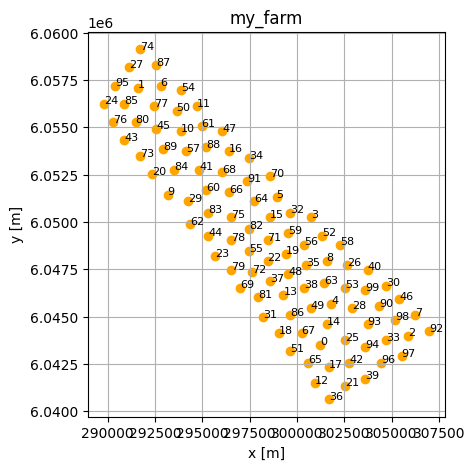

In [9]:
# create Wind Farm
farm = foxes.WindFarm(name="my_farm")

#----------------------------------------------Add Turbine----------------------------------------------#
current_path =  turbines_area_of_interest_path
#current_path = turbines_existing_path
#current_path = turbines_planned_future_path
#current_path = turbines_planned_in_operation_before_2030_path
#current_path = turbines_planned_netherlands_path

# # all Turbines (N.9.1-9.3)
# turb_files = os.listdir(current_path)
# dfs = [read_csv(current_path + file) for file in turb_files] #read files in path to dataframe and put's those in list 
# for dataframes in dfs:
#      foxes.input.farm_layout.add_from_df(
#           farm, 
#           dataframes,
#           turbine_models=["kTI_02", "NREL5MW"]
#           ) # also prints Turbines 'Turbine 0, T0: ' :(

#for testing
dataframes = read_csv("data/turbine-info/coordinates/area_of_interest/layout-N-9.3.geom.csv")
foxes.input.farm_layout.add_from_df(farm, dataframes,turbine_models=["kTI_02", "NREL5MW"])

# plot  with foxes
ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(5, 5))
plt.show()
#-------------------------------------------------------------------------------------------------------#

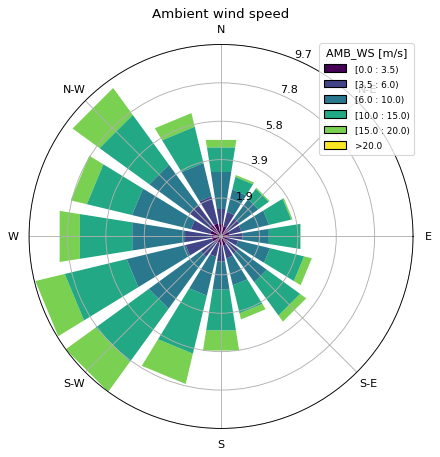

In [10]:
## get timeseries-data (here ERA5 as example)-------
from ERA5 import load_data,calculate_wind_speed,calculate_wind_direction,calculate_averages,check_data_gaps

Era5_path = 'data/reanalysis'  
start_year = 2000
end_year = 2001
    
Era5_data = load_data(Era5_path, start_year, end_year)
Era5_data = calculate_wind_speed(Era5_data)
Era5_data = calculate_wind_direction(Era5_data)
##--------------------------------------------------
data = Era5_data
data.columns

###----------------------------------------Add States-----------------------------------------###

# create the states object and have a look at the wind rose, look at input States 
# Wind and other atmospheric inflow conditions are called `States`
states = foxes.input.states.Timeseries(                           # StatesTable for panda df or pd readable file (single height)
    data_source = data ,                                           # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "WS100", FV.WD: "WD100", FV.TI: "ti"}, # Mapping from variable names to data column names

    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # ?? what is TI ?? sometimes also 0.08
)
# Plot windrose
o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()
###-------------------------------------------------------------------------------------------###

All models in *foxes* are selected by their names, i.e., Python `str` type objects. The mapping from those name strings to actual model objects (instances of the model classes) is provided by the so-called [ModelBook](https://github.com/FraunhoferIWES/foxes/blob/main/foxes/models/model_book.py):

In [11]:
mbook = foxes.ModelBook()
#mbook.print_toc()       # lists all models

algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_linear"],
    partial_wakes=None,
    # chunks={FC.STATE: 100, FC.POINT: 4000},  # STATE: how many States should be considered
    chunks={FC.STATE: 100},  # STATE: how many States should be considered   ?what does this do

    verbosity=0,
)

In [12]:

# We can now calculate the results: (for all 3 areas combined)
with foxes.utils.runners.DaskRunner(
    ) as runner:
    farm_results = runner.run(algo.calc_farm)     # calc_farm: Calculate farm data.
#-----------------------------------------------------------------------------------------------

o = foxes.output.FarmResultsEval(farm_results)
o.add_efficiency()

fig, axs = plt.subplots(2,1,figsize=(6, 7))
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(fig=fig, ax=axs[0], color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)
o.get_figure(fig=fig, ax=axs[1], color_by="mean_EFF", title="Mean efficiency [%]", s=150, annotate=0)
plt.show()

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P/1000:.1f} MW")
print(f"Farm ambient power: {P0/1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency()*100:.2f} %")
print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")


### For Area N9.1 + N9.2 + N9.3, as one computation (takes 40min)
# Farm power        : 870.7 MW
# Farm ambient power: 1052.0 MW
# Farm efficiency   : 82.76 %
# Annual farm yield : 7626.97 GWh


' \n# We can now calculate the results: (for all 3 areas combined)\nwith foxes.utils.runners.DaskRunner(\n    ) as runner:\n    farm_results = runner.run(algo.calc_farm)     # calc_farm: Calculate farm data.\n\no = foxes.output.FarmResultsEval(farm_results)\no.add_efficiency()\n\nfig, axs = plt.subplots(2,1,figsize=(6, 7))\no = foxes.output.FarmLayoutOutput(farm, farm_results)\no.get_figure(fig=fig, ax=axs[0], color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)\no.get_figure(fig=fig, ax=axs[1], color_by="mean_EFF", title="Mean efficiency [%]", s=150, annotate=0)\nplt.show()\n\no = foxes.output.FarmResultsEval(farm_results)\nP0 = o.calc_mean_farm_power(ambient=True)\nP = o.calc_mean_farm_power()\nprint(f"\nFarm power        : {P/1000:.1f} MW")\nprint(f"Farm ambient power: {P0/1000:.1f} MW")\nprint(f"Farm efficiency   : {o.calc_farm_efficiency()*100:.2f} %")\nprint(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")\n\n\n### For Area N9.1 + N9.2 + N9.3, as one co

## Task6

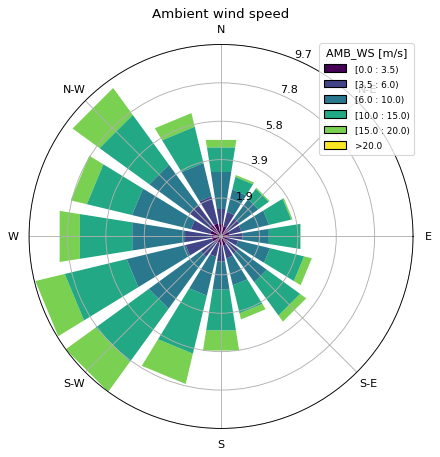

Turbine 0, T0: kTI_02, NREL5MW
Turbine 1, T1: kTI_02, NREL5MW
Turbine 2, T2: kTI_02, NREL5MW
Turbine 3, T3: kTI_02, NREL5MW
Turbine 4, T4: kTI_02, NREL5MW
Turbine 5, T5: kTI_02, NREL5MW
Turbine 6, T6: kTI_02, NREL5MW
Turbine 7, T7: kTI_02, NREL5MW
Turbine 8, T8: kTI_02, NREL5MW
Turbine 9, T9: kTI_02, NREL5MW
Turbine 10, T10: kTI_02, NREL5MW
Turbine 11, T11: kTI_02, NREL5MW
Turbine 12, T12: kTI_02, NREL5MW
Turbine 13, T13: kTI_02, NREL5MW
Turbine 14, T14: kTI_02, NREL5MW
Turbine 15, T15: kTI_02, NREL5MW
Turbine 16, T16: kTI_02, NREL5MW
Turbine 17, T17: kTI_02, NREL5MW
Turbine 18, T18: kTI_02, NREL5MW
Turbine 19, T19: kTI_02, NREL5MW
Turbine 20, T20: kTI_02, NREL5MW
Turbine 21, T21: kTI_02, NREL5MW
Turbine 22, T22: kTI_02, NREL5MW
Turbine 23, T23: kTI_02, NREL5MW
Turbine 24, T24: kTI_02, NREL5MW
Turbine 25, T25: kTI_02, NREL5MW
Turbine 26, T26: kTI_02, NREL5MW
Turbine 27, T27: kTI_02, NREL5MW
Turbine 28, T28: kTI_02, NREL5MW
Turbine 29, T29: kTI_02, NREL5MW
Turbine 30, T30: kTI_02, NREL5

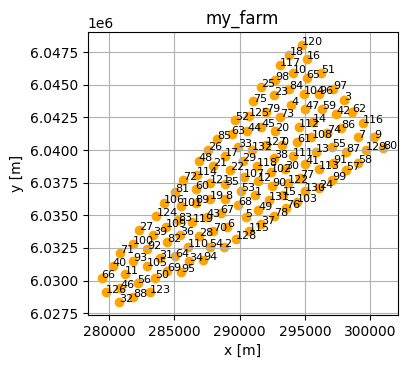

[########################################] | 100% Completed | 125.81 ms
[########################################] | 100% Completed | 581.75 s
Efficiency added to farm results


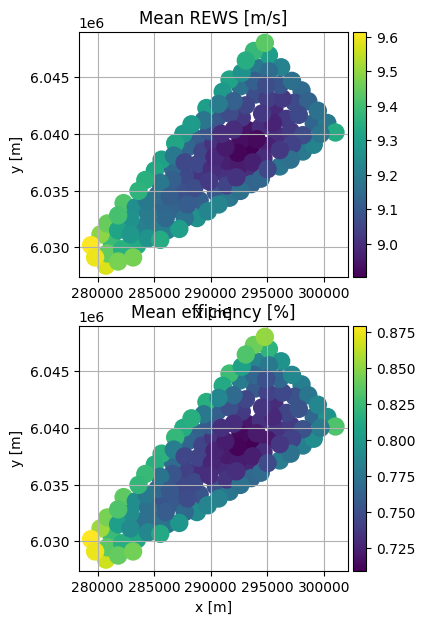


Farm power        : 337.2 MW
Farm ambient power: 382.3 MW
Farm efficiency   : 88.20 %
Annual farm yield : 2953.72 GWh
Turbine 0, T0: kTI_02, NREL5MW
Turbine 1, T1: kTI_02, NREL5MW
Turbine 2, T2: kTI_02, NREL5MW
Turbine 3, T3: kTI_02, NREL5MW
Turbine 4, T4: kTI_02, NREL5MW
Turbine 5, T5: kTI_02, NREL5MW
Turbine 6, T6: kTI_02, NREL5MW
Turbine 7, T7: kTI_02, NREL5MW
Turbine 8, T8: kTI_02, NREL5MW
Turbine 9, T9: kTI_02, NREL5MW
Turbine 10, T10: kTI_02, NREL5MW
Turbine 11, T11: kTI_02, NREL5MW
Turbine 12, T12: kTI_02, NREL5MW
Turbine 13, T13: kTI_02, NREL5MW
Turbine 14, T14: kTI_02, NREL5MW
Turbine 15, T15: kTI_02, NREL5MW
Turbine 16, T16: kTI_02, NREL5MW
Turbine 17, T17: kTI_02, NREL5MW
Turbine 18, T18: kTI_02, NREL5MW
Turbine 19, T19: kTI_02, NREL5MW
Turbine 20, T20: kTI_02, NREL5MW
Turbine 21, T21: kTI_02, NREL5MW
Turbine 22, T22: kTI_02, NREL5MW
Turbine 23, T23: kTI_02, NREL5MW
Turbine 24, T24: kTI_02, NREL5MW
Turbine 25, T25: kTI_02, NREL5MW
Turbine 26, T26: kTI_02, NREL5MW
Turbine 27

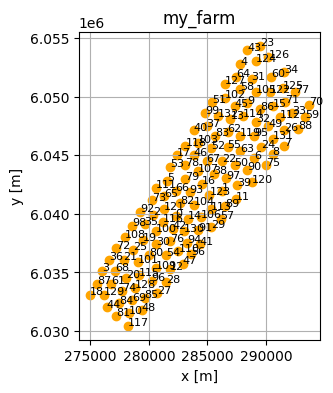

[########################################] | 100% Completed | 168.47 ms
[########################################] | 100% Completed | 587.89 s
Efficiency added to farm results


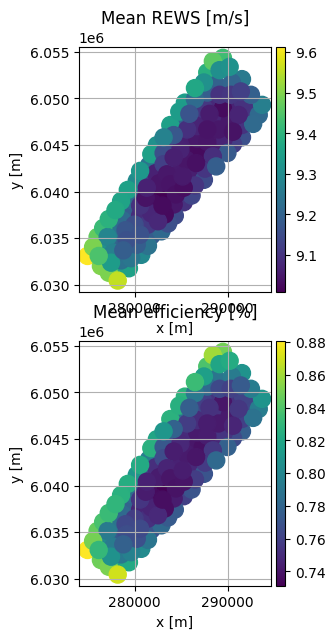


Farm power        : 338.7 MW
Farm ambient power: 382.3 MW
Farm efficiency   : 88.59 %
Annual farm yield : 2966.62 GWh
Turbine 0, T0: kTI_02, NREL5MW
Turbine 1, T1: kTI_02, NREL5MW
Turbine 2, T2: kTI_02, NREL5MW
Turbine 3, T3: kTI_02, NREL5MW
Turbine 4, T4: kTI_02, NREL5MW
Turbine 5, T5: kTI_02, NREL5MW
Turbine 6, T6: kTI_02, NREL5MW
Turbine 7, T7: kTI_02, NREL5MW
Turbine 8, T8: kTI_02, NREL5MW
Turbine 9, T9: kTI_02, NREL5MW
Turbine 10, T10: kTI_02, NREL5MW
Turbine 11, T11: kTI_02, NREL5MW
Turbine 12, T12: kTI_02, NREL5MW
Turbine 13, T13: kTI_02, NREL5MW
Turbine 14, T14: kTI_02, NREL5MW
Turbine 15, T15: kTI_02, NREL5MW
Turbine 16, T16: kTI_02, NREL5MW
Turbine 17, T17: kTI_02, NREL5MW
Turbine 18, T18: kTI_02, NREL5MW
Turbine 19, T19: kTI_02, NREL5MW
Turbine 20, T20: kTI_02, NREL5MW
Turbine 21, T21: kTI_02, NREL5MW
Turbine 22, T22: kTI_02, NREL5MW
Turbine 23, T23: kTI_02, NREL5MW
Turbine 24, T24: kTI_02, NREL5MW
Turbine 25, T25: kTI_02, NREL5MW
Turbine 26, T26: kTI_02, NREL5MW
Turbine 27

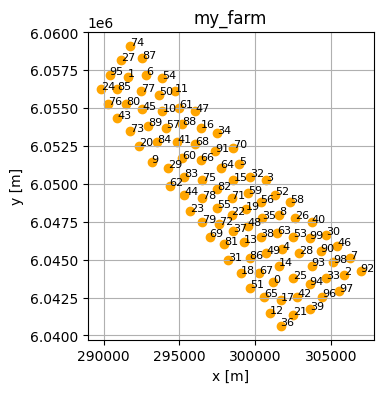

[########################################] | 100% Completed | 259.91 ms
[########################################] | 100% Completed | 441.74 s
Efficiency added to farm results


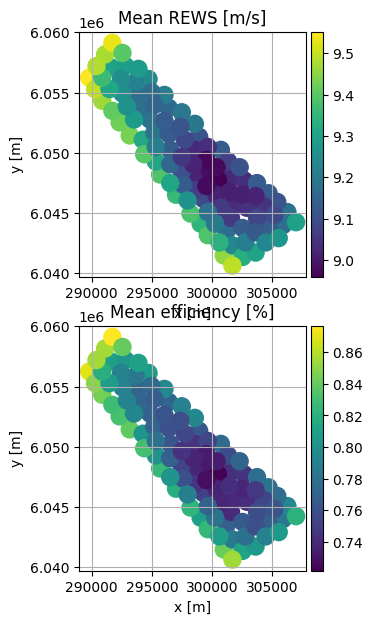


Farm power        : 255.4 MW
Farm ambient power: 287.4 MW
Farm efficiency   : 88.85 %
Annual farm yield : 2237.27 GWh


In [18]:
## Running each Area in a function

from Foxes_Farm_Power import Foxes_Farm_Power
# Foxes_Farm_Power(Farm_Layout,TType,States)
    # Farm   : pd.datafram containing Layout of Turbines
    # TType  : Typ of the Turbine  "NREL5MW" or "IEA15MW"
    # States : Wind conditions

#create Dataframe for Turbine Layout
turb_files = os.listdir(current_path)
Turb_dfs = [read_csv(current_path + file) for file in turb_files] #read files in path to dataframe and put's those in list 

# define States as Foxes object and have a look at the wind rose.
# Wind and other atmospheric inflow conditions are called `States`
States = foxes.input.states.Timeseries(                      # StatesTable for panda df or pd readable file (single height)
    data_source = data ,                                         # the data
    output_vars = [FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col =     {FV.WS: "WS100", FV.WD: "WD100", FV.TI: "ti"}, # Mapping from variable names to data column names
    fixed_vars =  {FV.RHO: 1.225, FV.TI: 0.05},                  # ?? what is TI ?? sometimes also 0.08
    )

# Plot windrose
o = foxes.output.StatesRosePlotOutput(states, point=[0., 0., 100.])
fig = o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

# Important Parameters
Parameters = dict(
    TType         = "NREL5MW",
    rotor_model   = "centre",
    wake_models   = ["Bastankhah2014_linear"],
    partial_wakes = None,
    )

# for Farm in Turb_dfs:
#     Foxes_Farm_Power(Farm,States,Parameters)

Farm_Results = []
for i in range(len(Turb_dfs)):
    Farm_Results.append(Foxes_Farm_Power(Turb_dfs[i],States,Parameters))



In [22]:
print()

NameError: name 'xarray' is not defined